# Introduction


**Table of Contents**
* [Preliminary imports](#imports)
* [Rectifications](#rectification)
* [Matching](#matching)
* [Compositon](#compositon)
* [Saving](#saving)

# Imports <a class="anchor" id="imports"></a>

In [1]:
from innotation_functions import *

In [2]:
from cadastre_matching import *

In [3]:
import os
#from matplotlib.pyplot import cm

In [4]:
%load_ext autoreload
%autoreload 2

# Rectifications <a class="anchor" id="rectification"></a>

This section offers ways to rectify the original images as well as associated files. Namely, here you can innotate them to perform the following processings.
* reorientation: to orient the cadastres up north (or other wished direction) 
* renaming: rename the cadastres' images files to ease further processes

## Initialization

In the cell below, fill depending on your configuration:
* `PATHS_TO_RECTIFY`: paths to the images to rectify 
    * if multiple:
        * files within these directory must have the same file names and represent the same entities
        * annotation will be made on files from the first directory in the list
* `img_ext`: extension of the images (if multiple, images within the directories must have the same extension)
* `reorient_input`: `True` to reorient the files, `False` otherwise
* `rename_input`: `True` to rename the files, `False` otherwise
* `new_filename_prefix`: prefix for the renamed files (used if `rename_input`=`True`)

In [5]:
PATHS_TO_RECTIFY = ["../LaRochelle_PoC/cadastres/", "../LaRochelle_PoC/lines_files/"]
img_ext = ".jpg"

reorient_input = False
rename_input = True
new_filename_prefix = "LaRochelle_1811_"

In [6]:
flnms = os.listdir(PATHS_TO_RECTIFY[0])
flnms = [fln for fln in flnms if fln.endswith(img_ext)]

flnms = [fln for fln in flnms if fln.endswith(img_ext)]


images = [cv2.imread(PATHS_TO_RECTIFY[0]+im) for im in flnms]

## Innotation

* Reorientation: orient the cadastres up north

    &#8594; first click on the southern part of the bearing arrow and then on the arrowhead (northern part).
    
* Renaming: rename the cadastres' images files to ease further processes

    &#8594; a window is displayed below the image, you can enter the label of the file there.
    
Click on <kbd>Next ></kbd> (or type <kbd>n</kbd>) when you have innotated the image. You can go to previous images by moving the slider or pressing <kbd>≤ Previous</kbd> (alternatively typing <kbd>p</kbd>).

In [7]:
innotater_rect, targets_rect = innotate_rectification(images
                                    , flnms
                                    , reorient = reorient_input
                                    , rename = rename_input
                                   )

In [8]:
display(innotater_rect)

Innotater(children=(VBox(children=(VBox(children=(Text(value='frad017_22_3p_5074_9.jpg', disabled=True), Image…

## Transformation

Run the following cell to transform the images according to your previous innotations. It will perform the transformation on the files present in the `PATHS_TO_RECTIFY`.

In [9]:
selected_images, selected_targets = perform_selection(targets_rect
                                                      , images
                                                      , flnms
                                                      , rename = rename_input
                                                     )

In [10]:
%%time
if reorient_input:
    rotation_angles = orientation_angles(targets_orient=selected_targets[2])
    selected_images = rotate_images(images=selected_images, orientation_angles=rotation_angles)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.25 µs


In [12]:
rectified_images = [selected_images]

for alt_path in PATHS_TO_RECTIFY[1:]:
    alt_images = [cv2.imread(alt_path+im) for im in flnms]
    
    alt_selected_images, alt_selected_targets = perform_selection(targets_rect
                                                                  , alt_images
                                                                  , flnms
                                                                  , rename = rename_input
                                                                 )
    
    if reorient_input:
        alt_selected_images = rotate_images(images=alt_selected_images, orientation_angles=rotation_angles)
        
    rectified_images += [alt_selected_images]

## Save rectified images

This section allows to save your rectifications by setting `SAVE_RECTIFIED` to `True`. 
You can insert the name of the new folder that will be created in `PATHS_TO_RECTIFY` directories (or use the default setting by letting `new_folder_name = ""`).

In addition, setting `SAVE_RECTIFIED_EDGES` to `True` offers a simple and quick way to denoise the images by computing the edges of the image and saving them. Note that this step is only performed on the images contained in the first directory of `PATHS_TO_RECTIFY`.

In [13]:
SAVE_RECTIFIED = True
SAVE_RECTIFIED_EDGES = True

new_folder_name = ""
if new_folder_name == "": # automatically sets new_folder_name if empty
    if reorient_input:
        new_folder_name += "reoriented"
    if rename_input:
        if reorient_input:
            new_folder_name += "_"
        new_folder_name += "renamed"

rectified_paths = [p+new_folder_name for p in PATHS_TO_RECTIFY]

In [14]:
if SAVE_RECTIFIED:
    for rectified_files, rectified_path in zip(rectified_images, rectified_paths):
        save_rectified_images(path=rectified_path+"/"
                              , rectified_images=rectified_files
                              , rectified_flnms=selected_targets[1]
                              , new_filename_prefix=new_filename_prefix
                              , img_ext=img_ext
                             )

In [15]:
if SAVE_RECTIFIED_EDGES:
    edges = [cv2.Canny(im,220,256) for im in rectified_images[0]]
    save_rectified_images(path=rectified_paths[0]+"_edges/"
                          , rectified_images=edges
                          , rectified_flnms=selected_targets[1]
                          , new_filename_prefix=new_filename_prefix
                          , img_ext=img_ext
                         )

# Matching <a class="anchor" id="matching"></a>

Here the magic begins to occur. After initialisation you can perform TM with the help of the machine. 

## Initialization

Set the following path:
* `FOLDER_ANNOT`: path to the images use to innotate (select templates)
* `FOLDER_COMPOSE`: path to the images use to compose the images (evaluation and reconstruction)
* `FOLDER_MATCH`: path to the images use to perform TM in the backend

In [5]:
FOLDER_ANNOT = "../LaRochelle_PoC/cadastres/renamed/"
FOLDER_COMPOSE = "../LaRochelle_PoC/lines_files/renamed/"
FOLDER_MATCH = "../LaRochelle_PoC/lines_files/renamed/"

Set the images prefix to easily access images using their labels. (Note that it should be the same in all the directories previously initialised)

In [6]:
img_prefix = "LaRochelle_1811_"

Set the suffix of the images to access. (Note that it should be the same in all the directories previously initialised)

In [7]:
img_ext = ".jpg"

## Matching process

First the network is inisialized empty. It will be filled with the matches found afterwards.

In [8]:
initialisation = True

In [9]:
# not to reinitialise by mistake and loose the work done
if initialisation and not ("G" in locals()):
    initialisation = False
    G = nx.DiGraph()
else:
    print("Do you really want to reinitialise the network ? (y/n)")
    reinit = input()
    if reinit == "y":
        G = nx.DiGraph()

In order to make the network grow and to compute matches the following cells should be run iteratively, following:
1. Run the next cell
    1. Type the label of the anchor cadastre <kbd>Enter</kbd>
    1. Type the label of the target cadastre <kbd>Enter</kbd><br />
    Both of the images will be displayed with the anchor cadastre on the left and the target one on the right.
    1. Select on the left cadastre the template.
    1. Select on the right cadastre the area on which to match the cadastre.
1. Run the second next cell<br />
     Adjust the range of the variable angles if needed, eg. to reduce calculation time<br />
     It is given as follows: `angles = np.linspace(min,max,N)`
     where `min` is the lower bound, `max` the upper one and `N` the number of angles linearly drawn between these values
    1. The composition based on the best match found will be displayed.
    1. The machine will ask you if the match is satisfying. 
        1. Type "`y`" if it is satisfying to store the match.<br />
           You can go back to step `1` and iterate.
        2. Type anything but "`y`" if the match is not satisfying. It will be discarded.<br />
           You can either select new template or matching area (go back to `1.C` or `1.D`) or dropping this pair for now and going back to step `1`.
1. Whenever you want to see the advances of your progresses you can go the third next cell to visualise the network or to the [next section](#composition) to see the composed image of the area covered.
1. Finally the fourth next cell is here if you saved a match that should have been discarded. Run it to go back to the previous state of the network.



In [23]:
anchor_label, target_label = initialize_match()

inw, targets = innotater_init(anchor_label
                              , target_label
                              , path=FOLDER_ANNOT+img_prefix
                              , im_ext=img_ext
                             )
display(inw)

Anchor cadaster label:  F1
Target cadaster label:  F2


Innotater(children=(VBox(children=(VBox(children=(HBox(children=(ImagePad(value=b'\xff\xd8\xff\xe0\x00\x10JFIF…

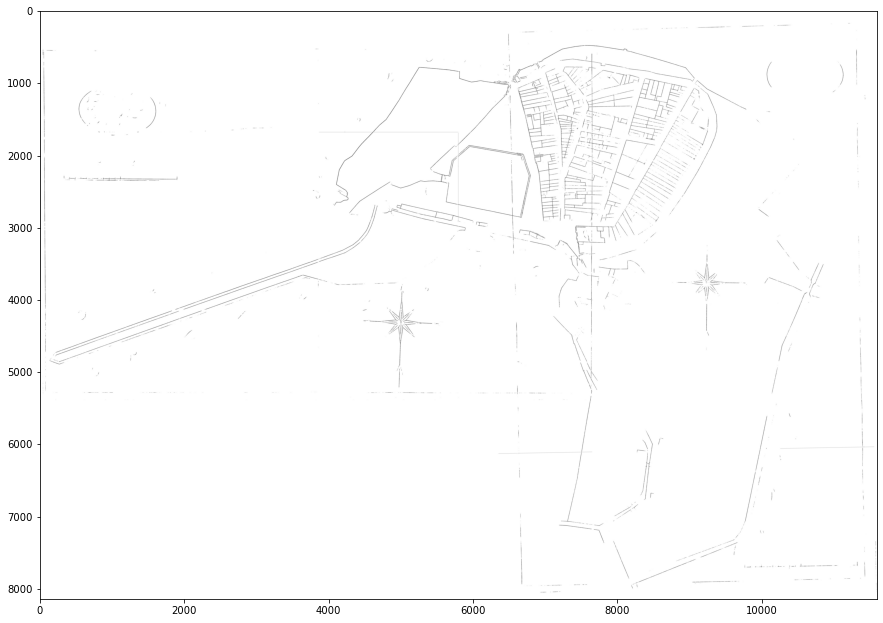

Is it OK?


 y


MATCH ADDED TO THE NETWORK
Current nodes:['A2', 'A1', 'B', 'C', 'D', 'E', 'F1', 'F2']


In [24]:
prev_G = G

G = test_match_network(targets
                       , path_match=FOLDER_MATCH+img_prefix
                       , anchor_label=anchor_label
                       , target_label=target_label
                       , img_ext=img_ext
                       , path_compose=FOLDER_COMPOSE+img_prefix
                       , G = G
                       , orientation_match = True
                       , angles = np.linspace(-40,41,80)
                      )

To have an glance on the state of the network built so far, you can run the following cell:

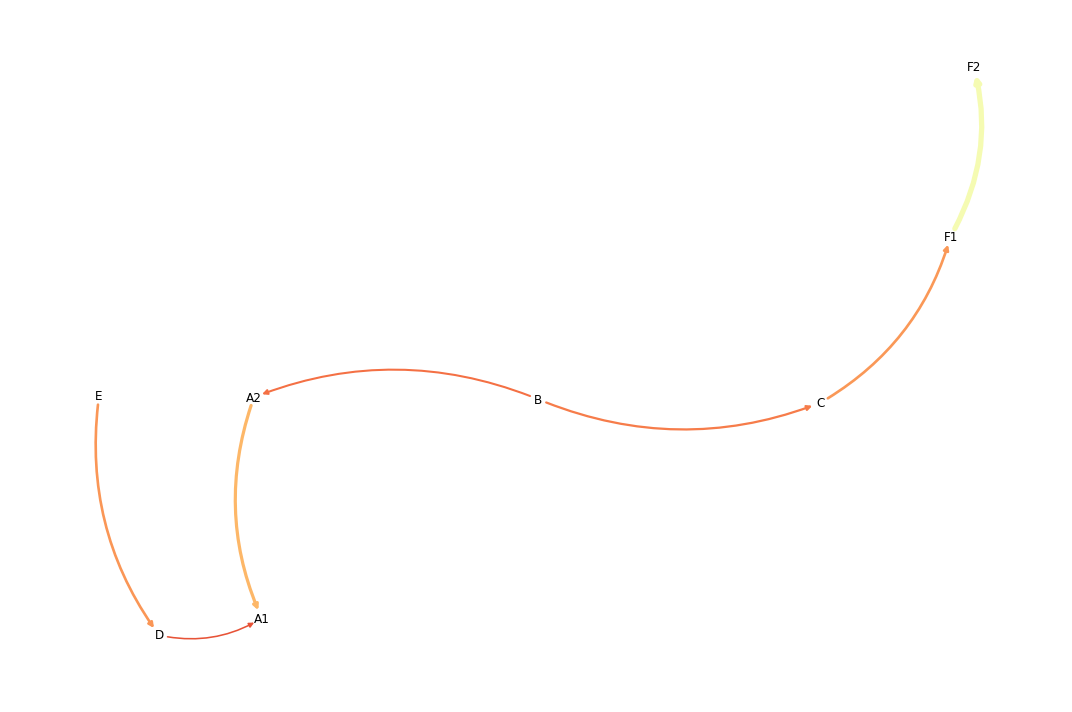

In [71]:
visualize_network(G)

In [26]:
print("Do you want to discard the last saved match ? (y/n) ")
reverse_step = input()
if reverse_step == "y":
    G = prev_G

Do you want to discard the last saved match ? (y/n) 


 n


# Composition <a class="anchor" id="composition"></a>

`network2Image` function allows to build the image of the area covered by the graph and connected to the initial cadastre given to the function as `init_label` (without consideration of directionnality).

Let the magic operate by running the following cells.

In [11]:
BigIm = network2Image(G
                      , init_label='A1'
                      , img_ext=img_ext
                      , path_compose=FOLDER_COMPOSE+img_prefix
                     )

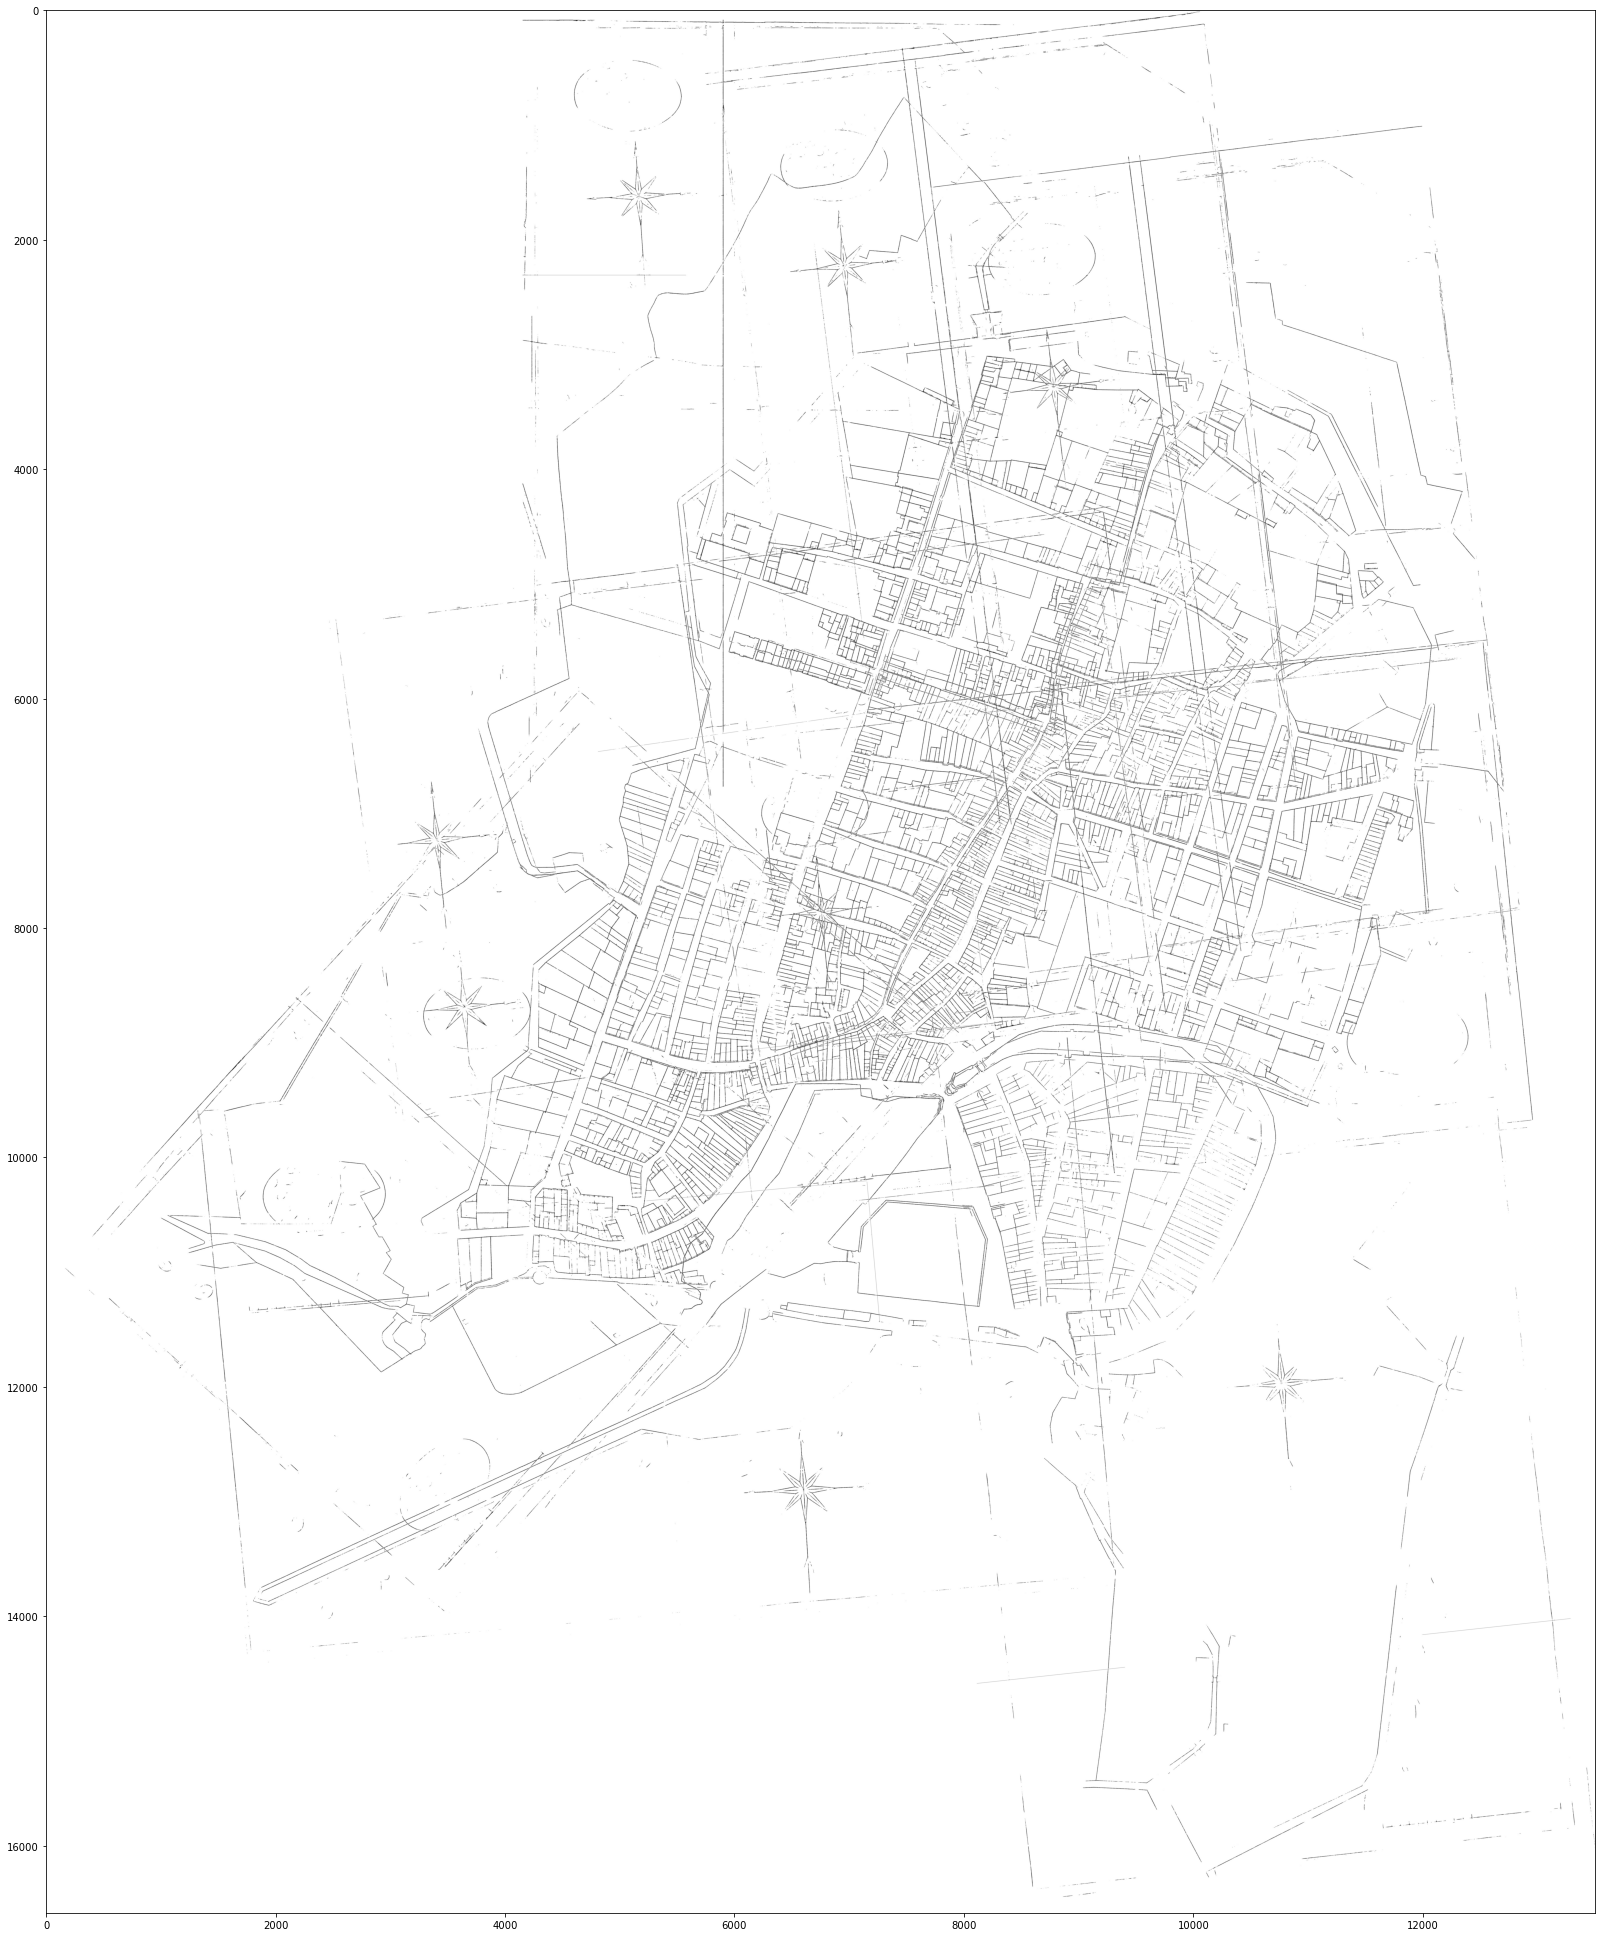

In [12]:
plt.figure(figsize=(35,35))
plt_plot_cv2(BigIm)

# Saving <a class="anchor" id="saving"></a>

By running the following cell, the will be stored as a `.json` file with the following structure:

```json
{
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [{
        "h": int — height of the corresponding image,
        "w": int — width of the corresponding image,
        "label": str — name
    }, {
        "h": int — height of the corresponding image,
        "w": int — width of the corresponding image,
        "label": str — name
    }],
    "match": [{
        "score": float — score of the template matching process,
        "anchor_tl": tuple: two int — coordinate of the template top left corner on the anchor,
        "anchor_br": tuple: two int — coordinate of the template bottom right corner on the anchor,
        "target_tl": tuple: two int — coordinate corresponding to anchor_tl on target,
        "target_br": tuple: two int — coordinate corresponding to anchor_br on target,
        "anchor": str — name of the anchor cadastre\node,
        "target": str — name of the target cadastre\node
    }]
}
```

The second next cell can be used to load previously saved graphs.

In [32]:
save_json_graph(G, path='../LaRochelle_PoC/RochellePoC.json')

In [10]:
G = load_json_graph(path='../LaRochelle_PoC/RochellePoC.json')